# Example: Making `tess-backdrop` weight files

`tess-backdrop` works by creating "weight" files. These small files contain the weights of the coefficients for the model, at every time. In this notebook, we'll show how to make one of those weight files.

For this, you'll need access to a stack of TESS FFIs. You'll also need to be on a machine with enough memory to make the design matrices involved in creating a backdrop. So long as you have >4Gb of memory, this shouldn't be an issue. 

In [6]:
import tess_backdrop as tbd

In this cell, we're just getting a stack of FFIs for `tess-backdrop` to work with. 

In [7]:
from glob import glob
import numpy as np

# This is a set of files I have locally
fnames = glob('/Volumes/Nibelheim/tess/sector01/camera01/ccd03/*')
fnames = np.sort(fnames)

Now we're going to make a `BackDrop` object. In other tutorials, we've used this object before. But in previous cases, we've never given `tess-backdrop` FFI files, and we haven't asked it to fit a model. This is what we're going to do below!

Here we're using the default parameters, but you can tune them to your use case if you like. In particular, changing the `nknots` parameter will increase the spatial resolution of the spline, but be careful, as this might lead to overfitting.

In this example, I'm going to fit 500 FFI files, but you can fit as many as you have or as many as you need. 

In [66]:
b = tbd.BackDrop(fnames=fnames[:500])

In [67]:
%%time
b.fit_model(save=False)

CPU times: user 31min 8s, sys: 10min 27s, total: 41min 36s
Wall time: 6min 45s


Now we've fit a model to a few frames, let's take a look at it! We can look at the weights of each model component if we like

In [68]:
b.poly_w.shape

(500, 29)

In [69]:
b.spline_w.shape

(500, 40, 40)

In [70]:
b.strap_w.shape

(500, 2048)

We have passed 500 files, which is why all the weight components have a shape in the first axis of 500. Then we have 29 total polynomial coefficients, 40 x 40 spline coefficients, and 2048 strap coefficients. Great!

We can save these coefficients to a file if we like. I'm specifying the output here, but if you don't specify anything these files will get saved to your `tess-backdrop` package directory.

In [71]:
b.save(output_dir='')

Here's a break down of the files that got made, and how large they are

In [72]:
!du -sh tessbackdrop*

360K	tessbackdrop_jitter_components_sector1_camera1_ccd3.fits
 19M	tessbackdrop_jitter_sector1_camera1_ccd3.fits
 96M	tessbackdrop_masks_sector1_camera1_ccd3.fits
 14M	tessbackdrop_sector1_camera1_ccd3.fits


Firstly, we've made a `masks` file. We can take a look at that file here:

In [73]:
from astropy.io import fits
fits.open('tessbackdrop_masks_sector1_camera1_ccd3.fits').info()

Filename: tessbackdrop_masks_sector1_camera1_ccd3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  STARMASK      1 ImageHDU         8   (2048, 2048)   int64   
  2  SATMASK       1 ImageHDU         8   (2048, 2048)   int64   
  3  AVGIMG        1 ImageHDU         8   (2048, 2048)   float64   


This file contains a mask which shows you which stars have been automatically masked, and which pixels have been masked due to saturation. It also contains the average image of the stack. 

More interesting to you may be the weights file

In [74]:
fits.open('tessbackdrop_sector1_camera1_ccd3.fits').info()

Filename: tessbackdrop_sector1_camera1_ccd3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1                1 BinTableHDU     14   500R x 2C   [D, D]   
  2                1 BinTableHDU     11   42R x 1C   [D]   
  3  SPLINE_W      1 ImageHDU         9   (40, 40, 500)   float64   
  4  STRAP_W       1 ImageHDU         8   (2048, 500)   float64   
  5  POLY_W        1 ImageHDU         8   (29, 500)   float64   


In this file we have all the information `tess-backdrop` needs to make the background model at any pixel, at any time. You can see the spline, strap and polynomial weights are embedded in this file. 

There are two other files that `tess-backdrop` has made which describe the jitter noise. There are two files, the `jitter_components` file, which is quite small. Let's take a look

In [75]:
fits.open('tessbackdrop_jitter_components_sector1_camera1_ccd3.fits').info()

Filename: tessbackdrop_jitter_components_sector1_camera1_ccd3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  JITTER_PIX    1 ImageHDU         8   (90, 500)   float64   


This contains just the top PCA components of the jitter noise. This is what `tess-backdrop` will use to fit out the jitter in your images.

If you want to see the jitter in more detail, you can look at the larger `jitter` file, which contains all of the test pixels `tess-backdrop` used to estimate the jitter.

In [76]:
fits.open('tessbackdrop_jitter_sector1_camera1_ccd3.fits').info()

Filename: tessbackdrop_jitter_sector1_camera1_ccd3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  JITTER_PIX    1 ImageHDU         8   (5000, 500)   float64   


By default `tess-backdrop` uses 5000 pixels as "test" pixels to assess the jitter. You can see those 5000 light curves in this 
file. You might not care about this light curves, you're most likely to want to use the jitter components.

Now that we know what `tess-backdrop` is doing, let's take a look at the model it's made. 

<ipython-input-77-c9dd3a4ea2fc>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(column, row, model, vmin=100, vmax=400);


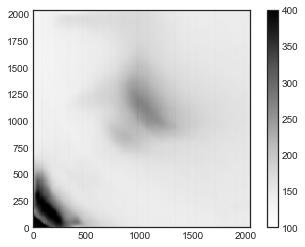

In [77]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

# These are the columns and rows we'll evaluate the model at
# We're evaluating it on a coarse grid, but we can do any grid we like
column, row = np.arange(0, 2048, 10), np.arange(0, 2048, 10)

# Here we evaluate the model at the first time, and plot it
model = b.build_model(column, row, 0)[0]
plt.pcolormesh(column, row, model, vmin=100, vmax=400);
plt.colorbar()
plt.gca().set_aspect('equal')

We can also evaluate just a small patch.

<ipython-input-80-4e88313d16e3>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(column, row, model, vmin=100, vmax=400);


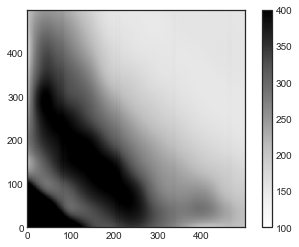

In [80]:
column, row = np.arange(0, 500), np.arange(0, 500)

# Here we evaluate the model at the first time, and plot it
model = b.build_model(column, row, 0)[0]
plt.pcolormesh(column, row, model, vmin=100, vmax=400);
plt.colorbar()
plt.gca().set_aspect('equal')

Looks good! Let's take a look at the jitter components. `tess_backdrop` splits the components into short, medium and long term systematics, so if we look at the top three components we'll see the most significant systematics at those time scales:

Text(0, 0.5, 'Normalized Component')

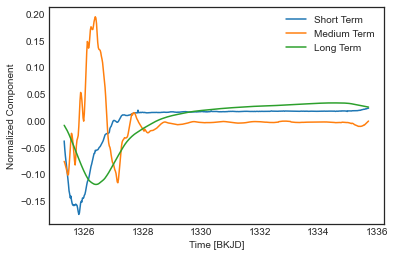

In [79]:
plt.plot(b.t_start, b.jitter_comps[:, :3], label=['Short Term', 'Medium Term', 'Long Term']);
plt.legend()
plt.xlabel('Time [BKJD]')
plt.ylabel('Normalized Component')

## How should I use this in practice?

If you want to make a lot of `tess-backdrop` files, I suggest you do something like this

```python
import tess-backdrop as tbd
fnames = ... # Your tess FFI file names
b = tbd.BackDrop(fnames=fnames)
b.fit_model()
b.save()
```

And then when you want to use your new files, `tess-backdrop` should load them automatically!